In [1]:
%matplotlib inline
import sys
sys.path.append("..")

# DeepTrack - Tracking multiple particles with a U-net

This notebook demonstrates how to use track multiple particles using a U-net with DeepTrack.

The U-net receives as input an image that may or may not contain particles and outputs an image of the same shape with pixel whose values are between 0 and 1. A pixel with a value closer to 1 indicates a high confidence that there is a particle close to that pixel, while a pixel with a value close to 0 inicates a high confidence that there is no nearby particle.

This tutorial should be read after the tutorials [deeptrack_introduction_tutorial](deeptrack_introduction_tutorial.ipynb) and [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

## 1. Setup

Imports needed for this tutorial.

In [2]:
from deeptrack.scatterers import PointParticle
from deeptrack.optics import Fluorescence
from deeptrack.noises import Poisson, Offset
from deeptrack.generators import Generator
from deeptrack.models import unet
from deeptrack.losses import weighted_crossentropy, sigmoid, flatten

import numpy as np
import matplotlib.pyplot as plt

## 2. Define the particle

For this example, we consider point particles (point light scatterers). A point particle is an instance of the class `PointParticle`, defined by its intensity and its position. Here, the position is randomized using a lambda function. More details can be found in the tutorial [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

In [3]:
particle = PointParticle(                                         
    intensity=100,
    position_unit="pixel",
    position=lambda: np.random.rand(2) * 256, 
)

## 3. Define the optics 

Next, we need to define the properties of the optical system. This is done using an instance of the class `Fluorescence`, which takes a set of light scatterers (particles) and convolves them with the pupil function (point spread function) of the optical system. More details can be found in the tutorial [tracking_particle_cnn_tutorial](tracking_particle_cnn_tutorial.ipynb).

In [4]:
Optics = Fluorescence(
    NA=0.7,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, 256, 256)
)

## 4. Define noises

We introduce two sources of noise:
1. A Poisson noise with SNR between 10 and 30.
2. A background offset between 0 and 1.

In [5]:
poisson_noise = Poisson(
    snr=lambda: np.random.rand()*30 + 20
)

offset = Offset(
    offset=lambda: np.random.rand()*1
)

## 5. Define the image features

We want images with a random number of particles between 1 and 10, a background offset, and Poisson noise.

In [6]:
num_particles = lambda: np.random.randint(1,11)

image_features = Optics(particle**num_particles) + offset + poisson_noise

## 6. Plot example images

Now, we visualize some example images. At each iteration, we call the method `.update()` to refresh the random features in the image (particle number, particle position, offset level, and Poisson noise). Afterwards we call the method `.plot()` to generate and display the image.

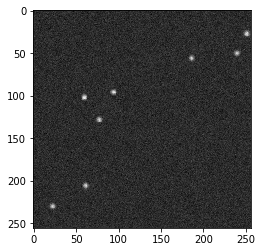

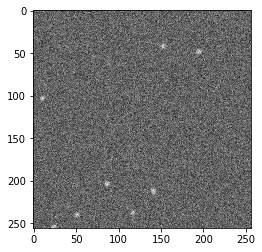

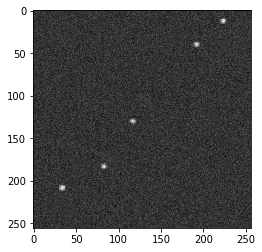

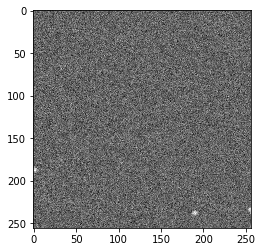

In [7]:
for i in range(4):
    image_features.update()
    output_image = image_features.plot(cmap="gray")

## 7. Create the target images

We define a function that uses the generated images to create the target images to be used in the training. We also show images and targets side by side.

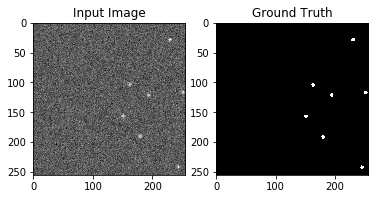

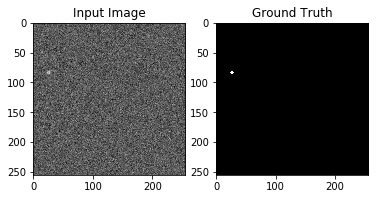

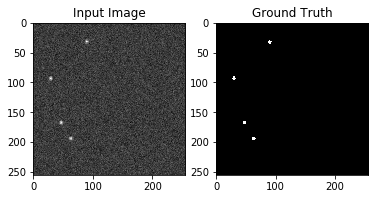

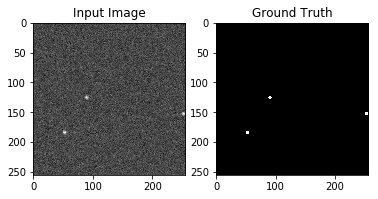

In [8]:
# Creates an image with circles of radius two at the same position 
# as the particles in the input image.
def get_target_image(image_of_particles):
    label = np.zeros(image_of_particles.shape)
    X, Y = np.meshgrid(
        np.arange(0, image_of_particles.shape[0]), 
        np.arange(0, image_of_particles.shape[1])
    )

    for property in image_of_particles.properties:
        if "position" in property:
            position = property["position"]

            distance_map = (X - position[1])**2 + (Y - position[0])**2
            label[distance_map < 9] = 1
    
    return label


for i in range(4):
    image_features.update()
    image_of_particles = image_features.resolve()

    target_image = get_target_image(image_of_particles)

    plt.subplot(1,2,1)
    plt.imshow(image_of_particles[:, :, 0], cmap="gray")
    plt.title("Input Image")
    
    plt.subplot(1,2,2)
    plt.imshow(target_image[:, :, 0], cmap="gray")
    plt.title("Ground Truth")
    
    plt.show()

## 8. Define image generator

We define a generator that creates images and targets in batches of 8.

In [9]:
generator = Generator().generate(
    image_features, 
    get_target_image,
    batch_size=8
)

## 9. Define the neural network model

The neural network architecture used is a U-Net, which is a fully convoltional model used for image to image transformations. Since the desired output is a binary image, we will be using crossentropy as loss. However, since target image is disproportionaly populated by 0s (any pixel is much more likely to be a zero than a one), we weight the loss such that false negatives are penalized ten times more than false positives. 

In [10]:
model = unet(
    (256, 256, 1), 
    conv_layers_dimensions=[8, 16, 32],
    base_conv_layers_dimensions=[32, 32], 
    loss=flatten(weighted_crossentropy((10, 1)))
)

W0211 11:54:01.299717 22508 deprecation.py:506] From c:\users\bmidt\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## 10. Train the model

The model is trained by calling `.fit()`.

In [11]:
model.fit(
    generator, 
    epochs=50,          
    steps_per_epoch=20
)

Epoch 1/50
20/20 [==============================] - 25s 1s/step - loss: 0.0442
Epoch 2/50
20/20 [==============================] - 24s 1s/step - loss: 0.0196
Epoch 3/50
20/20 [==============================] - 24s 1s/step - loss: 0.0148
Epoch 4/50
 5/20 [======>.......................] - ETA: 18s - loss: 0.0134

KeyboardInterrupt: 

## 11. Visualize the model performance

Finally we evaluate the model performance by showing the model output besides the input image and the ground truth.

In [ ]:
input_image, target_image = next(generator)

for i in range(input_image.shape[0]):
    
    predicted_image = model.predict(input_image)
    
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(input_image[i, :, :, 0]), cmap="gray")
    plt.title("Input Image")

    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(predicted_image[i, :, :, 0]), cmap="gray")
    plt.title("Predicted Image")
    
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(target_image[i, :, :, 0] > 0.5), cmap="gray")
    plt.title("Ground Truth")

    plt.show()